<a href="https://colab.research.google.com/github/ferjozsot23/student_grade_predictor/blob/main/Grade_of_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STUDENT GRADE PREDICTOR - MACHINE LEARNING
*Predict student grade with social factor* by Fernando Soto





# INTRODUCTION




Determinar la calificación final de un curso puede ser bastante impredecible, pero gracias a los algoritmos de aprendizaje automático, es posible anticipar con alta precisión el resultado considerando una variedad de factores sociales del estudiante, como el tiempo dedicado al estudio, su historial académico, la participación en actividades extracurriculares, la cantidad de horas de sueño, el uso de simuladores, y otros aspectos relevantes.

---

# LIBRARIES IMPORT

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, FunctionTransformer

# Validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Models

#Insert image
from IPython.display import Image

# Model persistance
import joblib

---

# GET THE DATA

In [ ]:
student_url = 'https://raw.githubusercontent.com/ferjozsot23/student_grade_predictor/main/Student_Performance.csv'
student = pd.read_csv(student_url)

---

# EXPLORATORY DATA ANALYSIS

In [ ]:
student.sample(5)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
5700,1,44,No,4,8,18.0
2092,7,69,No,5,3,57.0
7888,8,51,No,7,8,43.0
3531,5,85,Yes,5,4,69.0
217,3,93,Yes,7,1,73.0


* **Insight**: Se nota que existen 7 variables independientes por defecto en el dataset

In [ ]:
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


* **Insight**: No existen valores no nulos

In [ ]:
for col in student.columns:
  student.rename(
      columns={
      col: col.lower().replace(" ", "_")
      },
                 inplace=True)

student.rename(columns={"sample_question_papers_practiced": "simulators"}, inplace="True")
student

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,simulators,performance_index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


* **Comentario**: Se cambia el nombre de la varaible sample_questions a simulator para mayor entendimiento

In [ ]:
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hours_studied               10000 non-null  int64  
 1   previous_scores             10000 non-null  int64  
 2   extracurricular_activities  10000 non-null  object 
 3   sleep_hours                 10000 non-null  int64  
 4   simulators                  10000 non-null  int64  
 5   performance_index           10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [ ]:
np.sort(student["hours_studied"].unique())

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
corr_matrix = student.corr()
corr_matrix["performance_index"].sort_values(ascending=False)

<ipython-input-9-75af11d954e3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = student.corr()


performance_index    1.000000
previous_scores      0.915189
hours_studied        0.373730
sleep_hours          0.048106
simulators           0.043268
Name: performance_index, dtype: float64

* **Insight**: Las notas anteriores como las horas estudiandas tienen un gran correlación positiva con la variable dependiente

# Prepare the Data for Machine Learning Algorithms

## Feature Engineering

In [ ]:
# Definir los límites de los buckets para Sleep Hours
bins = [0, 4, 7, float('inf')]
labels = ['Bajo', 'Medio', 'Alto']

# Crear la nueva variable 'sleep_hours_buckets'
student['sleep_hours_buckets'] = pd.cut(student['sleep_hours'], bins=bins, labels=labels, right=False)
student

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,simulators,performance_index,sleep_hours_buckets
0,7,99,Yes,9,1,91.0,Alto
1,4,82,No,4,2,65.0,Medio
2,8,51,Yes,7,2,45.0,Alto
3,5,52,Yes,5,2,36.0,Medio
4,7,75,No,8,5,66.0,Alto
...,...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0,Medio
9996,7,64,Yes,8,5,58.0,Alto
9997,6,83,Yes,8,5,74.0,Alto
9998,9,97,Yes,7,0,95.0,Alto


Crear nuevas features relacionadas entre sí

In [ ]:
student["hours_per_simulator"] = student["hours_studied"] / student["simulators"]
student = student.replace([np.inf, -np.inf], np.nan)

* **Comentario**: La relación entre horas estudiadas por simulador pueden ser relevantes para la variable dependiente

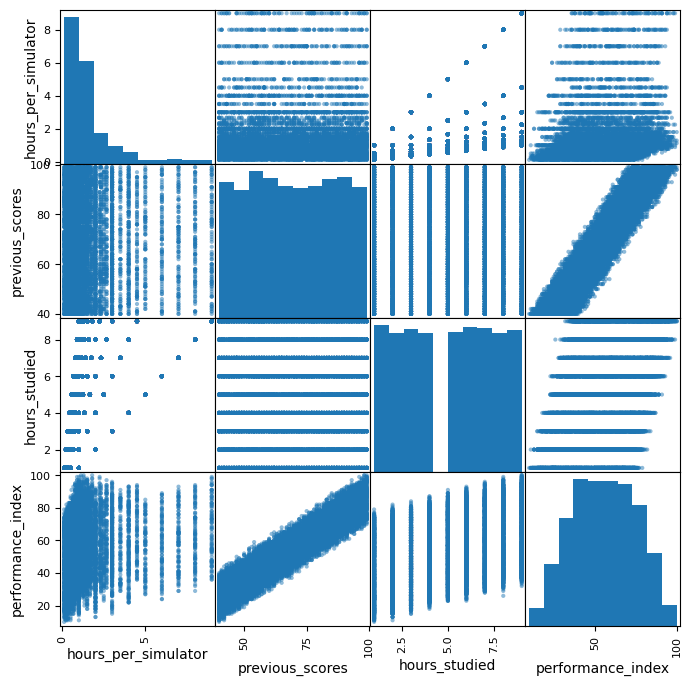

In [ ]:
attributes = ["hours_per_simulator", "previous_scores", "hours_studied", "performance_index"]

scatter_matrix(student[attributes], figsize=(8, 8))
plt.show()

* **Insight**: Existe una clara correlación entre las columnas hours_per_simulator, previous_scores y hours_studied con la variable target

Crear una nueva característica que capture la relación no lineal con Sleep Hours


In [ ]:
student['sleep_hours_squared'] = student['sleep_hours'] ** 2
# O raíz cuadrada
student['sqrt_sleep_hours'] = np.sqrt(student['sleep_hours'])
corr_matrix = student.corr()
corr_matrix["performance_index"].sort_values(ascending=False)

<ipython-input-14-15ec1dcfca16>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = student.corr()


performance_index      1.000000
previous_scores        0.915189
hours_studied          0.373730
hours_per_simulator    0.159882
sleep_hours_squared    0.048470
sleep_hours            0.048106
sqrt_sleep_hours       0.047727
simulators             0.043268
Name: performance_index, dtype: float64

* **Insight**: No existe relación con las nuevas variables creadas

In [ ]:
student.drop(columns=["sqrt_sleep_hours", "sleep_hours_squared"],inplace=True)

In [ ]:
corr_matrix = student.corr()
corr_matrix["performance_index"].sort_values(ascending=False)

<ipython-input-16-75af11d954e3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = student.corr()


performance_index      1.000000
previous_scores        0.915189
hours_studied          0.373730
hours_per_simulator    0.159882
sleep_hours            0.048106
simulators             0.043268
Name: performance_index, dtype: float64

## Estratificación

In [ ]:
student

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,simulators,performance_index,sleep_hours_buckets,hours_per_simulator
0,7,99,Yes,9,1,91.0,Alto,7.0
1,4,82,No,4,2,65.0,Medio,2.0
2,8,51,Yes,7,2,45.0,Alto,4.0
3,5,52,Yes,5,2,36.0,Medio,2.5
4,7,75,No,8,5,66.0,Alto,1.4
...,...,...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0,Medio,0.5
9996,7,64,Yes,8,5,58.0,Alto,1.4
9997,6,83,Yes,8,5,74.0,Alto,1.2
9998,9,97,Yes,7,0,95.0,Alto,NaN


In [ ]:
student.drop(columns=["sleep_hours_buckets", "hours_per_simulator"], inplace=True)
student

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,simulators,performance_index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


In [ ]:

strat_train_set, strat_test_set = train_test_split(
    student,
    test_size=0.2,
    random_state=42
    )

In [ ]:
student = strat_train_set.drop("performance_index", axis=1)
student_label = strat_train_set["performance_index"].copy()

* **Comentario**: Antes de entrenar los algoritmos, es importante estratificar los datos entre prueba y test para evitar sobreajuste

---

# CLEANING DATA PIPELINE

In [ ]:
# Imputer missing values hours per simulator
# One hot encoding extracurricular
# Standarized previous score

In [ ]:
# Crear el cat_pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

* **Comentario**: Se crea un pipeline para las variables categóricas

In [ ]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    RobustScaler(),
    StandardScaler()
    )


* **Comentario**: Se crea un pipeline para las variables numéricas

In [ ]:
def column_ratio(X):
    x0 = X[:, 0].astype(float)
    x1 = X[:, 1].astype(float)
    ratio = np.divide(x0, x1, out=np.zeros_like(x0), where=x1 != 0)

    return ratio.reshape(-1, 1)

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="constant", fill_value=0),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())


* **Comentario**: Se definen las funciones que serán usadas para crear nuevos atributos

In [ ]:
preprocessing = ColumnTransformer([
    ('cat', cat_pipeline, ["extracurricular_activities"]),
    ('hours_per_simulator', ratio_pipeline(), ["hours_studied", "simulators"]),
    ('num', num_pipeline, make_column_selector(dtype_include=["int", "float"])),

],
    remainder='passthrough'  # Tratar otras columnas no mencionadas como "passthrough"
)

# Aplicar las transformaciones
student_preprocessed = preprocessing.fit_transform(student)

pd.DataFrame(student_preprocessed, columns=preprocessing.get_feature_names_out(), index=student.index)


,cat__extracurricular_activities_No,cat__extracurricular_activities_Yes,hours_per_simulator__ratio,num__hours_studied,num__previous_scores,num__sleep_hours,num__simulators
9254,1.0,0.0,-0.226514,0.006455,-1.183844,0.269888,0.134041
1561,0.0,1.0,-0.633604,-1.149747,-1.241506,0.269888,0.483562
1670,1.0,0.0,-0.226514,-1.149747,0.661318,0.269888,-0.914520
6087,1.0,0.0,0.384120,-1.149747,-1.356828,-0.318906,-1.264041
6669,1.0,0.0,-0.837149,1.162658,-1.299167,1.447477,-1.613561
...,...,...,...,...,...,...,...
5734,0.0,1.0,-0.022970,1.162658,-1.126183,-0.318906,0.483562
5191,1.0,0.0,-0.022970,-0.378946,-0.088279,1.447477,-0.565000
5390,1.0,0.0,0.078803,1.548059,-1.241506,0.269888,0.483562
860,1.0,0.0,-0.837149,-1.535148,-1.299167,1.447477,-1.613561


* **Comentario**: Dataframe después de aplicar el transformer "preprocessing"

---

# SELECT AND TRAIN A MODEL

* **Comentario**: Una vez que se ha construido el transformer se puede pasar a entrenar el modelo

In [ ]:
X = student
y = student_label


# Linear Regressor

In [ ]:
from sklearn.linear_model import LinearRegression

model_lin_reg = make_pipeline(
    preprocessing,
    LinearRegression()
)

model_lin_reg.fit(X, y )


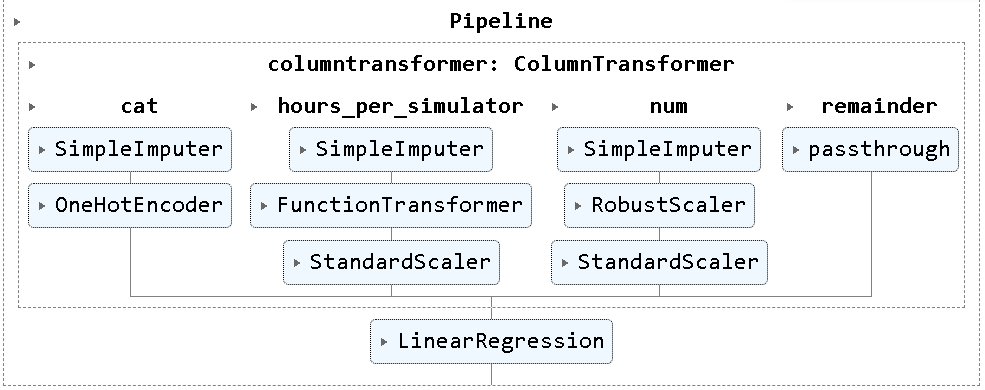

In [12]:
url_lr = "https://raw.githubusercontent.com/ferjozsot23/student_grade_predictor/main/pipeline%20images/p.lr.png"
Image(url_lr,  width=600)

In [ ]:
score = model_lin_reg.score(student, student_label)
score

0.988689141496066

Cross-validation

In [ ]:
# Entrenar y hacer las validaciones 9 veces para sacar 10 rmse
model_lr_rmse = -cross_val_score(
    model_lin_reg,
    X, y,
    scoring="neg_root_mean_squared_error", cv=10)
pd.DataFrame(model_lr_rmse).describe()

,0
count,10.000000
mean,2.043720
std,0.058709
min,1.954144
25%,2.007378
50%,2.024014
75%,2.089653
max,2.140849


# SVM Regressor

In [ ]:
from sklearn.svm import SVR
model_svr = make_pipeline(
    preprocessing,
    SVR()  # Puedes ajustar los hiperparámetros aquí según sea necesario
)

# Entrenar el modelo SVR
model_svr.fit(X, y)

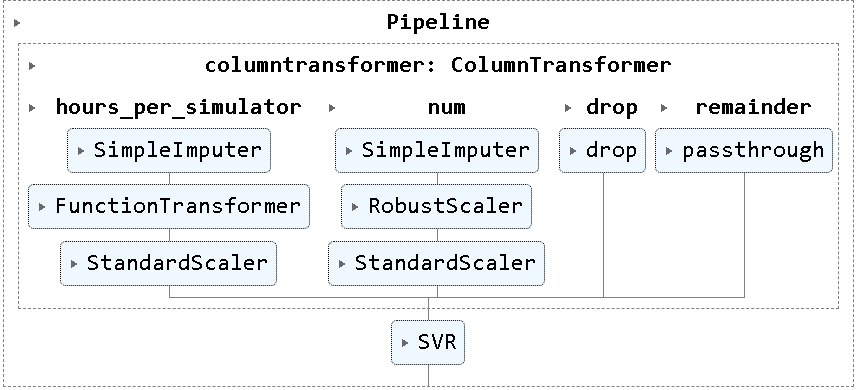

In [13]:
url_svr = "https://raw.githubusercontent.com/ferjozsot23/student_grade_predictor/main/pipeline%20images/l.svr.png"
Image(url_svr,  width=600)

In [ ]:
score = model_svr.score(X, y)
score

0.9847490655021562

In [ ]:
svm_rmse = -cross_val_score(
    model_svr,
    X , y,
    scoring="neg_root_mean_squared_error",
    cv=10)

pd.DataFrame(svm_rmse).describe()

,0
count,10.000000
mean,2.446933
std,0.075118
min,2.333066
25%,2.397257
50%,2.439694
75%,2.481843
max,2.584477


## DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model_tree_reg = make_pipeline(
    preprocessing,
    DecisionTreeRegressor(random_state=42)
)

model_tree_reg.fit(X, y)


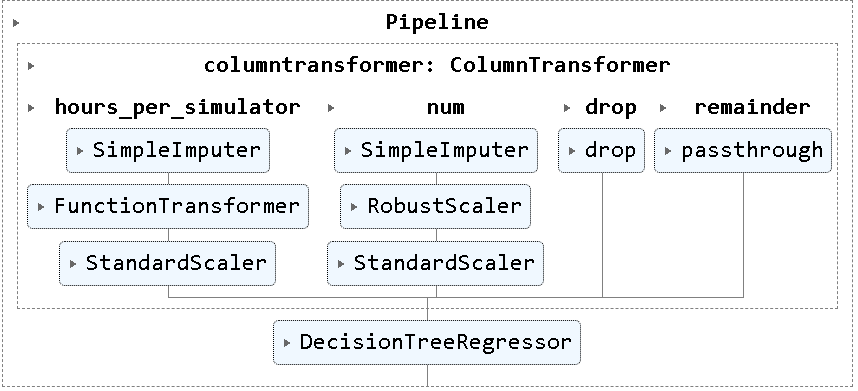

In [14]:
url_dt = "https://raw.githubusercontent.com/ferjozsot23/student_grade_predictor/main/pipeline%20images/p.dt.png"
Image(url_dt,  width=600)

In [ ]:
tree_rmses = -cross_val_score(
    model_tree_reg,
    X , y,
    scoring="neg_root_mean_squared_error",
    cv=10)

pd.DataFrame(tree_rmses).describe()


,0
count,10.000000
mean,3.039166
std,0.080451
min,2.931374
25%,2.972027
50%,3.038565
75%,3.090752
max,3.170885


## RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)
model_forest_reg.fit(X, y)

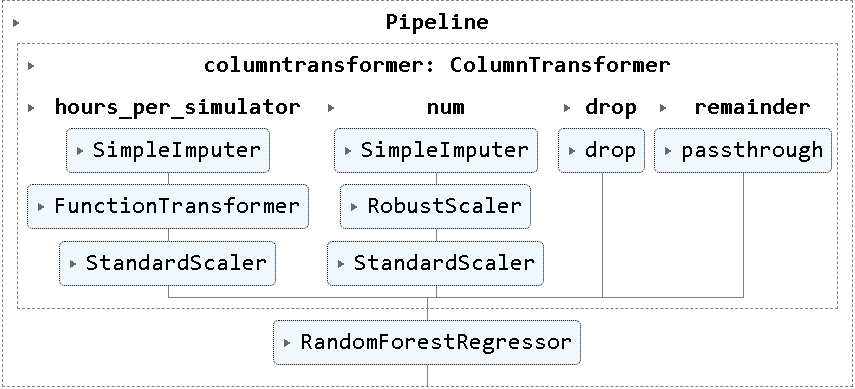

In [15]:
url_rf = "https://raw.githubusercontent.com/ferjozsot23/student_grade_predictor/main/pipeline%20images/p.rf.png"
Image(url_rf,  width=600)

Cross-validation

In [ ]:
# Entrena y hace las validaciones 9 veces para sacar 10 rmse
forest_rmses = -cross_val_score(
    model_forest_reg,
    X, y,
    scoring="neg_root_mean_squared_error", cv=10)
pd.DataFrame(forest_rmses).describe()

,0
count,10.000000
mean,2.382962
std,0.063084
min,2.291651
25%,2.342337
50%,2.378384
75%,2.420936
max,2.505374


Comparising

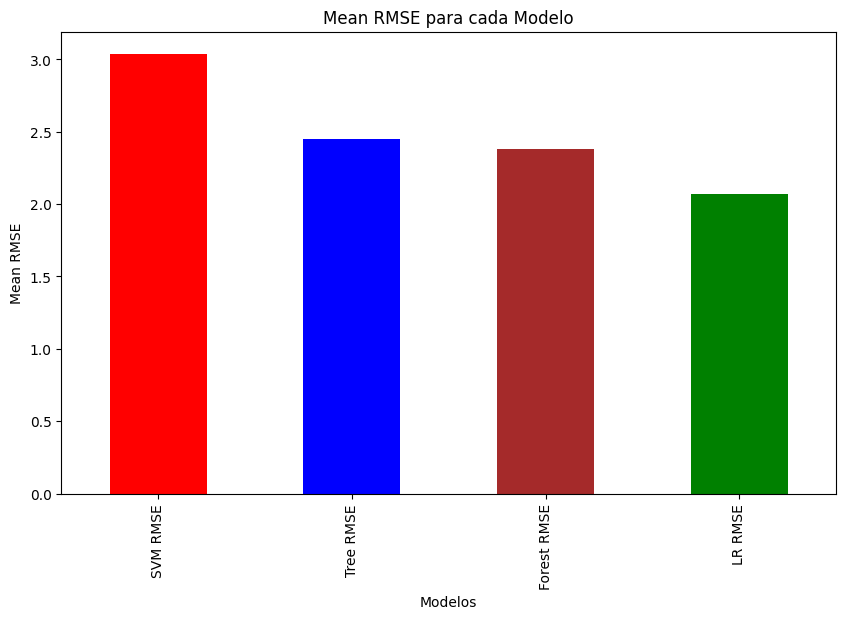

In [ ]:
result_df = pd.concat([pd.Series(forest_rmses), pd.Series(model_lr_rmse), pd.Series(tree_rmses), pd.Series(svm_rmse)], axis=1)
result_df.columns=['Forest RMSE', 'LR RMSE', 'SVM RMSE','Tree RMSE']

max_values = result_df.mean().sort_values(ascending=False)

# Crear el diagrama de barras
max_values.plot(kind='bar', figsize=(10, 6), color=['red', 'blue', 'brown', 'green'])

# Añadir etiquetas y título
plt.xlabel('Modelos')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE para cada Modelo')


# Mostrar el diagrama de barras
plt.show()

* **Insight**: El modelo que tiene menor RMSE es Linear Regressor

In [ ]:
result_df.mean().sort_values()

LR RMSE        2.065985
Forest RMSE    2.382962
Tree RMSE      2.446933
SVM RMSE       3.039166
dtype: float64

---

# FINE TUNE LINEAR REGRESSION

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
   'linearregression__fit_intercept': [True, False],
}

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(
    model_lin_reg,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=10)

# Entrenar el modelo con búsqueda aleatoria
random_search.fit(X, y)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)

# Mostrar el mejor RMSE encontrado
print("Mejor RMSE:", -random_search.best_score_)

final_model_lr = random_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros: {'linearregression__fit_intercept': True}
Mejor RMSE: 2.065984709669477


---



# Evaluating on test set

In [ ]:
strat_test_set

,hours_studied,previous_scores,extracurricular_activities,sleep_hours,simulators,performance_index
6252,5,69,No,8,2,51.0
4684,2,46,Yes,4,8,20.0
1731,7,56,Yes,7,5,46.0
4742,6,42,Yes,8,5,28.0
4521,7,53,No,4,6,41.0
...,...,...,...,...,...,...
6412,2,70,No,7,3,45.0
8285,4,79,No,9,3,66.0
7853,2,40,Yes,7,2,16.0
1095,3,83,No,7,5,65.0


In [ ]:
X_test = strat_test_set.drop("performance_index", axis=1)
y_test = strat_test_set["performance_index"].copy()

* **Comentario**: Se crean los dos conjuntos de datos, con las observaciones para predecir y la variable tarjet

In [ ]:
final_predictions = final_model_lr.predict(X_test)

* **Comentario**: Se predice las observaciones no antes vistas con el modelo Lineal Regressor

In [ ]:
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print("RMSE: ", final_rmse)

r2 = r2_score(y_test, final_predictions)
print("R2 score: ", r2)

RMSE:  2.0450402222138053
R2 score:  0.9887146317272162


---

# Model persistence using joblib

In [ ]:
joblib.dump(final_model_lr, "student_final_score_model.pkl")

['student_final_score_model.pkl']

---

# Deploying model

In [ ]:
nuevo_registro = pd.DataFrame([{"hours_studied": 9, "previous_scores":87, "extracurricular_activities": "Yes", "sleep_hours":7, "simulators": 5}])
final_model_reloaded = joblib.load("student_final_score_model.pkl")

predictions = final_model_reloaded.predict(nuevo_registro)
predictions

array([84.82812859])